# Import

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import os, joblib, math, shap
import numpy as np
import pandas as pd

from matplotlib import lines
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
plt.rcParams['font.family'] = 'Helvetica'

import seaborn as sns

from tensorflow.keras import Sequential
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Input, Concatenate

# Load Data

## RNA

In [4]:
rna = pd.read_csv('../../data/processed/RNA_train_cancergenes.csv', index_col=0)

## Drugs

In [5]:
drugs = pd.read_csv('../../data/processed/drug_fingerprints.csv', index_col=0)

## CDR

In [6]:
cdr = pd.read_csv('../../data/processed/drugCellLinePairsData.csv')
cdrFilt = cdr.loc[:, ['DepMap_ID', 'cancer_type', 'name', 'ic50', 'auc', 'effectiveCont', 'effective']]
cdrFilt.rename(columns={'DepMap_ID': 'cell_line', 'name': 'drug', 'effective': 'true'}, inplace=True)
cdrFilt.head()

,cell_line,cancer_type,drug,ic50,auc,effectiveCont,true
0,ACH-000320,Pancreatic Cancer,floxuridine,0.007879,0.336463,6.692422,0
1,ACH-001145,Ovarian Cancer,floxuridine,0.041552,0.485618,5.053845,0
2,ACH-000873,Esophageal Cancer,floxuridine,0.097745,0.548483,4.697597,0
3,ACH-000855,Esophageal Cancer,floxuridine,0.037349,0.631609,4.052632,0
4,ACH-000488,Esophageal Cancer,floxuridine,0.071628,0.598061,3.801377,0


## Data

In [7]:
cdr = cdrFilt[cdrFilt.cell_line.isin(rna.index)]
cdr100 = shap.utils.sample(cdr, 100)
cdr = shap.utils.sample(cdr, 5000)

data = [drugs.loc[list(cdr.drug.values), :].to_numpy(), 
        rna.loc[list(cdr.cell_line.values), :].to_numpy()]

d100 = [drugs.loc[list(cdr100.drug.values), :].to_numpy(), 
        rna.loc[list(cdr100.cell_line.values), :].to_numpy()]

# Get feature importances

In [8]:
ftImportance = {}
joblib.dump(ftImportance, './ftImportances.joblib')

['./ftImportances.joblib']

## RF

In [9]:
rf1 = f'../../models/SiamCDR/RF/EmbedDrug-EmbedCell-RF-CVfold0.joblib'
rf2 = f'../../models/SiamCDR/RF/EmbedDrug-EmbedCell-RF-CVfold1.joblib'
rf3 = f'../../models/SiamCDR/RF/EmbedDrug-EmbedCell-RF-CVfold2.joblib'
rf4 = f'../../models/SiamCDR/RF/EmbedDrug-EmbedCell-RF-CVfold3.joblib'
rf5 = f'../../models/SiamCDR/RF/EmbedDrug-EmbedCell-RF-CVfold4.joblib'
rfs = [rf1, rf2, rf3, rf4, rf5]

cols = [f'drug{i+1}' for i in range(64)]+[f'cell{i+1}' for i in range(64)]
rfDF = pd.DataFrame(index=['f1', 'f2', 'f3', 'f4', 'f5'], columns=cols)
for i, m in enumerate(rfs):
    m = joblib.load(m)
    rfDF.loc[f'f{i+1}', :] = np.abs(m.feature_importances_)

In [10]:
rfDF

,drug1,drug2,drug3,drug4,drug5,drug6,drug7,drug8,drug9,drug10,...,cell55,cell56,cell57,cell58,cell59,cell60,cell61,cell62,cell63,cell64
f1,0.00337,0.009158,0.011919,0.006133,0.005655,0.002692,0.010173,0.030813,0.02316,0.006533,...,0.0,0.0,0.002026,0.0,0.0,0.000312,0.027497,0.0,0.0,0.0
f2,0.002431,0.007445,0.009678,0.005867,0.004945,0.003138,0.013224,0.028269,0.02333,0.006316,...,0.0,0.0,0.001413,0.0,0.0,0.0,0.02831,0.0,0.0,0.0
f3,0.003363,0.006573,0.008676,0.005013,0.008046,0.002064,0.011936,0.028657,0.023506,0.007459,...,0.0,0.0,0.00151,0.0,0.0,0.000228,0.02887,0.0,0.0,0.0
f4,0.004394,0.006391,0.011883,0.005991,0.007498,0.002582,0.009166,0.031732,0.022998,0.008451,...,0.0,0.0,0.002075,0.0,0.0,0.000219,0.028481,0.0,0.0,0.0
f5,0.002814,0.006725,0.011703,0.007038,0.005902,0.002804,0.011445,0.031999,0.023006,0.006697,...,0.0,0.0,0.001919,0.0,0.0,0.000286,0.02592,0.0,0.0,0.0


In [11]:
# Shows stability of importances across folds
rfDF.var().max()

1.4390809643160715e-05

In [12]:
rfSeries = rfDF.mean()

In [13]:
ftImportance['rf'] = rfSeries[rfSeries> 0.].sort_values(ascending=False)

In [14]:
joblib.dump(ftImportance, './ftImportances.joblib')

['./ftImportances.joblib']

In [15]:
ftImportance = joblib.load('./ftImportances.joblib')

## LR

In [16]:
m2 = f'../../models/SiamCDR/LR/RawDrug-EmbedCell-LR-CVfold1.joblib'
m1 = f'../../models/SiamCDR/LR/RawDrug-EmbedCell-LR-CVfold0.joblib'
m3 = f'../../models/SiamCDR/LR/RawDrug-EmbedCell-LR-CVfold2.joblib'
m4 = f'../../models/SiamCDR/LR/RawDrug-EmbedCell-LR-CVfold3.joblib'
m5 = f'../../models/SiamCDR/LR/RawDrug-EmbedCell-LR-CVfold4.joblib'
ms = [m1, m2, m3, m4, m5]

cols = [f'drug{i+1}' for i in range(256)]+[f'cell{i+1}' for i in range(64)]
mDF = pd.DataFrame(index=['f1', 'f2', 'f3', 'f4', 'f5'], columns=cols)
for i, m in enumerate(ms):
    m = joblib.load(m)
    mDF.loc[f'f{i+1}', :] = m.coef_

In [17]:
print(mDF.apply(np.abs).mean().max())
print(mDF.apply(np.abs).mean().mean())
print(mDF.var().max())
print(mDF.var().mean())

1.5032193762876798
0.38565925721023875
0.051283679256261046
0.007994646629072824


In [18]:
mDF = mDF.apply(np.abs)

In [19]:
mSeries = mDF.mean().sort_values(ascending=False)
mSeries

drug229    1.503219
drug98     1.476053
drug101    1.453606
drug1      1.435434
drug197    1.434560
             ...   
cell5      0.000072
cell10     0.000069
cell42     0.000062
cell43     0.000061
cell17     0.000061
Length: 320, dtype: float64

In [20]:
ftImportance['lr'] = mSeries
joblib.dump(ftImportance, './ftImportances.joblib')

['./ftImportances.joblib']

## DNN

### Load model

In [21]:
dnnBasePath = '../../models/SiamCDR/DNN/'
dnnName = f'RawDrug-EmbedCell-DNN_NL64_64_DO0-1_AFrelu_LR0-01_DR0-99_DS500_CVfold1'
dnnModelPath = os.path.join(dnnBasePath, dnnName)
dnn = load_model(dnnModelPath)

In [22]:
dnn.summary()

Model: "FS-CDR"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 256)]        0           []                               
                                                                                                  
 input_10 (InputLayer)          [(None, 463)]        0           []                               
                                                                                                  
 pairEncoder (Functional)       (None, 320)          38016       ['input_9[0][0]',                
                                                                  'input_10[0][0]']               
                                                                                                  
 dense_12 (Dense)               (None, 64)           20544       ['pairEncoder[0][0]']       

In [23]:
embedDNN = dnn.get_layer('pairEncoder')

In [24]:
subDNN = Sequential()
subDNN.add(Input(shape=embedDNN.outputs[0].shape[1]))
for layer in dnn.layers[3:]:
    subDNN.add(layer)

### SHAP feature importance

In [25]:
cols = [f'drug{i+1}' for i in range(256)]+[f'cell{i+1}' for i in range(64)]

d = embedDNN(data).numpy()
dataDF = pd.DataFrame(d, columns=cols)

d100_ = embedDNN(d100).numpy()
d100DF = pd.DataFrame(d100_, columns=cols)

In [ ]:
explainer = shap.Explainer(subDNN.predict, d100DF)
vals = explainer(dataDF, max_evals=650).values
valDF = pd.DataFrame(vals, columns=cols)

In [19]:
ftImportance = joblib.load('./ftImportances.joblib')

In [21]:
ftImportance['dnn'] = valDF.apply(np.abs).max().sort_values(ascending=False)

In [22]:
joblib.dump(ftImportance, './ftImportances.joblib')

['./ftImportances.joblib']

## DeepDSC

### Load model

In [31]:
dsc = load_model('../../models/DeepDSC/DeepDSC_best')

In [36]:
drugInput = Input(shape=256, name='drugFPs')
rnaInput = Input(shape=463, name='rna')
AE = dsc.get_layer('encoder')
comb = Concatenate()([AE(rnaInput), drugInput])
embedDSC = Model(inputs=[drugInput, rnaInput], outputs=comb)

In [34]:
dnn = dsc.get_layer('dnn')
dnn.summary()

Model: "dnn"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 RnaEncoded (InputLayer)        [(None, 32)]         0           []                               
                                                                                                  
 DrugFingerprintInput (InputLay  [(None, 256)]       0           []                               
 er)                                                                                              
                                                                                                  
 concatenate_14 (Concatenate)   (None, 288)          0           ['RnaEncoded[0][0]',             
                                                                  'DrugFingerprintInput[0][0]']   
                                                                                                

In [37]:
subDSC = Sequential()
subDSC.add(Input(shape=embedDSC.outputs[0].shape[1]))
for layer in dsc.layers[3:]:
    subDSC.add(layer)

AssertionError: Exception encountered when calling layer "dnn" (type Functional).

Could not compute output KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='Output/Sigmoid:0', description="created by layer 'Output'")

Call arguments received:
  • inputs=tf.Tensor(shape=(None, 288), dtype=float32)
  • training=False
  • mask=None

### SHAP feature importance

In [14]:
cols = [f'cell{i+1}' for i in range(32)] + [f'drug{i+1}' for i in range(256)]

d = embedDSC(data).numpy()
dataDF = pd.DataFrame(d, columns=cols)

d100_ = embedDSC(d100).numpy()
d100DF = pd.DataFrame(d100_, columns=cols)

In [15]:
explainer = shap.Explainer(subDSC.predict, d100DF)
vals = explainer(dataDF, max_evals=650).values
valDF = pd.DataFrame(vals, columns=cols)

Permutation explainer: 5001it [1:43:09,  1.24s/it]                          


In [16]:
ftImportance = joblib.load('./ftImportances.joblib')

In [18]:
ftImportance['dsc'] = valDF.apply(np.abs).max().sort_values(ascending=False)

In [19]:
joblib.dump(ftImportance, './ftImportances.joblib')

['./ftImportances.joblib']

# Visualize pred correlation to effective score with respect to each drug

In [9]:
ftImportance = joblib.load('./ftImportances.joblib')

In [10]:
def minMaxNorm(series):
    return (series - series.min()) / (series.max() - series.min())

def plotBiColorLine(subplot, x, c, w):
    # plot line
    subplot.axhline(x, linestyle='-', linewidth=w+1, color='black')
    subplot.axhline(x, linestyle='-', linewidth=w, color=c)
    
    # get patch for legend
    dl1 = lines.Line2D([], [], linestyle="-", linewidth=w+1,  color='black')
    dl2 = lines.Line2D([], [], linestyle="-", linewidth=w, color=c)
    return (dl1, dl2)

def vizImportance(subplt, series, txt, xloc, drugColor='#377eb8', cellColor='#e41a1c', addLegend=False):
    # Scale importances and sort
    series = minMaxNorm(series)
    avgDrugImportance = series[series.index.str.startswith('drug')].mean()
    avgCellImportance = series[series.index.str.startswith('cell')].mean()
    series = series[series > 0.01].sort_values(ascending=False)
    if series.shape[0] > 100:
        series = series.iloc[:100]
    
    
    # define bar colors
    colors = []
    for idx in series.index:
        if idx.startswith('drug'):
            colors.append(drugColor)
        else:
            colors.append(cellColor)
    
    # plot feature importance
    subplt.bar(series.index, series.values, color=colors, edgecolor='black', linewidth=0.5)
    
    # plot avg importance by feature type
    cellLinePatch = plotBiColorLine(subplt, avgCellImportance, cellColor, 3)
    drugLinePatch = plotBiColorLine(subplt, avgDrugImportance, drugColor, 3)
    
    subplt.text(xloc, 0.95, txt,
                color='black', weight='bold')
    
    # create legend
    if addLegend:
        drugFtPatch = mpatches.Patch(color=drugColor)
        drugFtLabel= 'Drug features'
        cellFtPatch = mpatches.Patch(color=cellColor)
        cellFtLabel = 'Cell line features'
        
        handles = [drugFtPatch, cellFtPatch, 
                   drugLinePatch, cellLinePatch]
        labels = [drugFtLabel, 
                  cellFtLabel, 
                 'Avg relative drug feature importance', 
                 'Avg relative cell line feature importance']
        
        subplt.legend(handles, labels, loc=1, fontsize=20)
    
    # format plot
    subplt.set_xlim([0-0.5,len(series)-0.5])
    subplt.set_xticks([])
    subplt.set_ylim([0.0,1.0])
    subplt.set_yticks([0,1], labels=['0', '1'], fontsize=15)

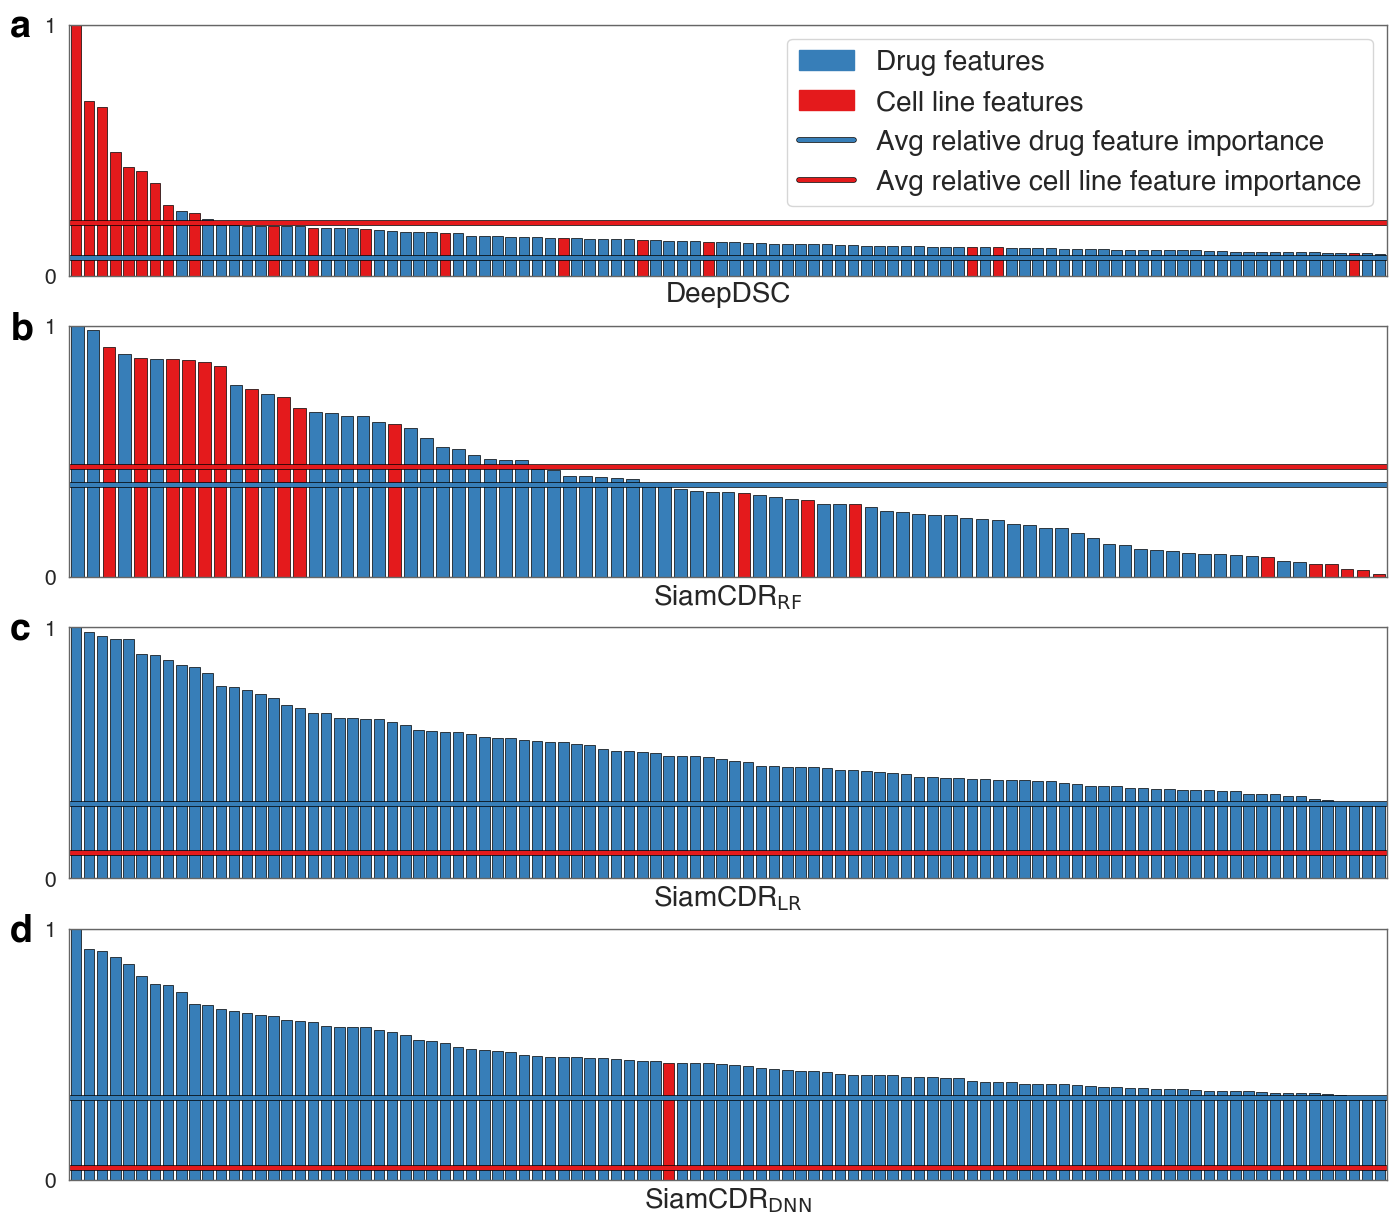

In [12]:
sns.set_theme()
sns.set_context("paper")
sns.set(font_scale = 2.25)
rc = {'axes.facecolor': 'white',
      'axes.grid': True,
      'grid.color': '0.8',
      'font.family': 'sans-serif',
      'font.sans-serif': 'Helvetica'}
plt.rcParams.update(rc)


fig, ax = plt.subplots(4, figsize=(17,15))
for name, vals in ftImportance.items():
    if 'dsc' in name.lower():
        m = 'DeepDSC'; r = 0; c = 0; leg=True; txt = 'a'; xloc = -5
    elif 'rf' in name.lower():
        m = "SiamCDR$_{\mathrm{RF}}$"; r = 1; c = 1; leg=False; txt = 'b'; xloc = -4.2
    elif 'lm' in name.lower():
        m = "SiamCDR$_{\mathrm{LR}}$"; r = 2; c = 0; leg=False; txt = 'c'; xloc = -5
    elif 'dnn' in name.lower():
        m = "SiamCDR$_{\mathrm{DNN}}$";  r = 3; c = 1; leg=False; txt = 'd'; xloc = -5
        
    subplt = ax[r]#[c]
    vizImportance(subplt, vals, txt, xloc, drugColor='#377eb8', cellColor='#e41a1c', addLegend=leg)
    subplt.set_xlabel(m, fontsize=20)
    for border in ['top', 'bottom', 'left', 'right']:
        subplt.spines[border].set_visible(True)
        subplt.spines[border].set_color("0.4")
        subplt.spines[border].set_linewidth(1)

plt.savefig("./figure3.pdf", dpi=1200, bbox_inches="tight")
plt.show()